<h1>HW4</h1>

104061172 張肇元

<h1>Introduction</h1>

這次的作業流程是載入 google AI research 的文件來做 cluster 分析，利用的方法有 k-means k-means++ LDA FCM Agglomerative，AI research 的文件相關性一般來說會和 machine learning 這主題的關聯性非常高，這是一份同質性很高，很難好好地分出類別的作業，同時由於要用5種演算法，所以我每一次都會跑完 data 的 preprocessing 就跳去寫該種演算法，比起之前都是線性流程，這次真的非常複雜，難度也很高。
策略是先用 LDA 對 data 進行分類，所以我能非常直觀的知道這個 data 裡面大概可以分幾類還有它重要的部分。
然後再分成
1.用單字
2.用段落
來分類。

<h1>Implement</h1>

In [1]:
import codecs
import re
import pandas as pd
import csv
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
import nltk
from matplotlib import cm
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import pyLDAvis
import pyLDAvis.sklearn
import spacy
import gensim
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
import pickle
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

D:\anaconda\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
D:\anaconda\lib\site-packages\scipy\sparse\sparsetools.py:21: DeprecationWarning: `scipy.sparse.sparsetools` is deprecated!
scipy.sparse.sparsetools is a private module for scipy.sparse, and should not be used.
  _deprecated()


In [2]:
with open(os.path.join(r"D:\ML", "hw4.csv"), encoding='utf8') as csvfile:
    df = pd.read_csv(csvfile,header = 0)
    listbuf = df['title_abstract'].values.tolist()

    data = [re.sub('\\s+', ' ', i) for i in listbuf]
    data = [re.sub('[^a-zA-Z0-9]', ' ', i) for i in data]
    data = [re.sub(' e g ', 'for example', i) for i in data]

預處理的部分就是把奇怪的標點符號，換行等清掉。

<h1> LDA </h1>

In [3]:
ver1pre = np.array(data).reshape(len(df))
count = CountVectorizer(stop_words='english',max_df = 0.1,min_df = 0.001,max_features=5000)

In [4]:
x = count.fit_transform(ver1pre)
lda = LatentDirichletAllocation(n_components = 5,random_state=0)
X_topics = lda.fit_transform(x)
lda.components_.shape

(5, 5000)

In [5]:
top_words = 10
feature_token = count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ,".join([feature_token[i] for i in topic.argsort()[:-top_words - 1 : -1]]))

Topic 1:
video ,videos ,image ,object ,images ,content ,latency ,visual ,motion ,3d
Topic 2:
sequence ,input ,recurrent ,end ,random ,prediction ,accuracy ,output ,speech ,architecture
Topic 3:
graph ,semantic ,query ,quantum ,clustering ,space ,image ,datasets ,queries ,framework
Topic 4:
speech ,recognition ,optimization ,acoustic ,optimal ,trained ,word ,translation ,target ,error
Topic 5:
web ,online ,software ,mobile ,security ,privacy ,code ,internet ,experience ,services


可以看到 count vector 把 networks 和 network 分開了，但是我的目標是把這份 csv 分成主題式的 cluster 所以我覺得這樣子分是不太合理的，因為我們希望的是讓 videos 可以還原成原本的詞，這樣可以比較促進分類的效果。
所以
1.我決定加強 preprocessing 的效果
我除了老師的把字變成字跟之外，我另外又對文字動了一些手腳，首先因為大寫很分成不同類是很不合理的，另外文章中有數字其實是看不出來她和主題的關聯性質的，也應該被取消掉。
2.我想要知道在一篇很相近，都在講 AI research 的文章，如果我們把它的類別分超級開會是甚麼樣的情形，但是我們必須先把 s 取消掉。

In [6]:
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()
class LemmaCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmaCountVectorizer, self).build_analyzer()
        return lambda doc: (lemm.lemmatize(w) for w in analyzer(doc))

In [7]:
ver2_count = LemmaCountVectorizer(max_df=0.1,min_df=0.001,stop_words='english',max_features=5000)
ver2_data = ver2_count.fit_transform(ver1pre)

In [8]:
ver2topics = lda.fit_transform(ver2_data)

In [9]:
top_words = 10
feature_token = ver2_count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ,".join([feature_token[i] for i in topic.argsort()[:-top_words - 1 : -1]]))

Topic 1:
video ,object ,frame ,quantum ,interaction ,human ,content ,action ,3d ,representation
Topic 2:
speech ,distributed ,code ,memory ,latency ,optimization ,recognition ,source ,power ,modeling
Topic 3:
mobile ,device ,control ,web ,query ,traffic ,gesture ,medium ,social ,email
Topic 4:
online ,ad ,service ,software ,web ,survey ,privacy ,experience ,advertising ,challenge
Topic 5:
sequence ,word ,input ,function ,trained ,prediction ,graph ,domain ,label ,speech


效果變好了，在 Topic 1 中， video frame action 是很相關的東西，Topic 2 中 speece voice acoustic speaker 也是， Topic 3 的 mobile device gesture social
(讓我想到 iphone的 smart gesture)，也是，Topic 4 ad 和 advertiser 完全重複了， Topic 5 看的出來和程式有關，不過我擔憂它和 Topic 6 很類似而，Topic 7 又和 Topic 6
有重複的字眼，我覺得分 7 種太多了，試試看5種好了。

In [10]:
lda = LatentDirichletAllocation(n_components = 5,random_state=0)

In [11]:
ver2topics = lda.fit_transform(ver2_data)

In [12]:
top_words = 10
feature_token = ver2_count.get_feature_names()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ,".join([feature_token[i] for i in topic.argsort()[:-top_words - 1 : -1]]))

Topic 1:
video ,object ,frame ,quantum ,interaction ,human ,content ,action ,3d ,representation
Topic 2:
speech ,distributed ,code ,memory ,latency ,optimization ,recognition ,source ,power ,modeling
Topic 3:
mobile ,device ,control ,web ,query ,traffic ,gesture ,medium ,social ,email
Topic 4:
online ,ad ,service ,software ,web ,survey ,privacy ,experience ,advertising ,challenge
Topic 5:
sequence ,word ,input ,function ,trained ,prediction ,graph ,domain ,label ,speech


確實有些類別是非常相關的，比如說主題1的 video frame ，但是我覺得主題2和主題5還有主題3主題4分得不太好...
會不會這個 model 的極限是3呢?

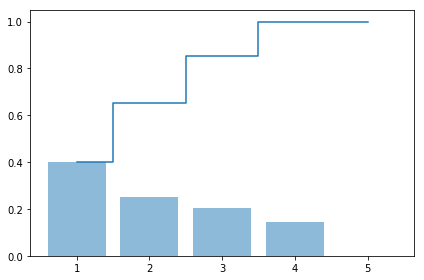

In [14]:
cov_data = np.array(ver2topics)
cov_mat = np.cov(cov_data.T)
eigenvals , eigenvec = np.linalg.eig(cov_mat)
tot = sum (eigenvals)
var_exp  = [(i/tot) for i in sorted(eigenvals , reverse= True)]
cum_var_exp =  np.cumsum(var_exp)
plt.bar(range(1,6), var_exp[0:5] ,alpha = 0.5 , align = 'center')
plt.step(range(1,6),cum_var_exp[0:5],where = 'mid')
plt.tight_layout()
plt.show()

從 eigen value 則可以看到 topic 5的影響可以說是為微乎其微阿!
所以在 lda model 應該是無法分成 5 種的。

In [15]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(lda, ver2_data, ver2_count, mds='tsne')
panel

D:\anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      129.744476 -126.740196       1        1  29.707528
3      132.345139  -62.604279       2        1  21.985661
1       64.210297 -116.013443       3        1  19.651100
0       46.154072  -54.608311       4        1  16.662012
2       95.428574  -10.089098       5        1  11.993699, topic_info=     Category        Freq            Term       Total  loglift  logprob
term                                                                   
4855  Default  579.000000           video  579.000000  30.0000  30.0000
3044  Default  347.000000          object  347.000000  29.0000  29.0000
2882  Default  259.000000          mobile  259.000000  28.0000  28.0000
4058  Default  388.000000        sequence  388.000000  27.0000  27.0000
194   Default  267.000000              ad  267.000000  26.0000  26.0000
4235  Default  433.000000          speech  433.000000  25.0000  25.0000
1341  Default  295.000000          device  295.000000  24.0000  24.0000
1451  Default  306.000000     distributed  306.000000  23.0000  23.0000
3081  Default  436.000000          online  436.000000  22.0000  22.0000
4066  Default  345.000000         service  345.000000  21.0000  21.0000
4410  Default  222.000000          survey  222.000000  20.0000  20.0000
4185  Default  262.000000        software  262.000000  19.0000  19.0000
3567  Default  131.000000         quantum  131.000000  18.0000  18.0000
1063  Default  247.000000         control  247.000000  17.0000  17.0000
249   Default  148.000000     advertising  148.000000  16.0000  16.0000
834   Default  255.000000            code  255.000000  15.0000  15.0000
4922  Default  490.000000             web  490.000000  14.0000  14.0000
4956  Default  312.000000            word  312.000000  13.0000  13.0000
1745  Default  240.000000      experience  240.000000  12.0000  12.0000
478   Default  141.000000         auction  141.000000  11.0000  11.0000
3437  Default  194.000000         privacy  194.000000  10.0000  10.0000
2578  Default  178.000000         latency  178.000000   9.0000   9.0000
1950  Default  181.000000           frame  181.000000   8.0000   8.0000
2811  Default  279.000000          memory  279.000000   7.0000   7.0000
4584  Default  252.000000         trained  252.000000   6.0000   6.0000
4011  Default  206.000000        security  206.000000   5.0000   5.0000
4580  Default  153.000000         traffic  153.000000   4.0000   4.0000
68    Default  102.000000              3d  102.000000   3.0000   3.0000
2034  Default   85.000000         gesture   85.000000   2.0000   2.0000
2802  Default  158.000000          medium  158.000000   1.0000   1.0000
...       ...         ...             ...         ...      ...      ...
3285   Topic5   43.883015           photo   49.061356   2.0092  -6.0683
3921   Topic5   45.375860            root   52.929922   1.9668  -6.0349
3314   Topic5   54.359717          planet   65.404129   1.9358  -5.8542
2971   Topic5   20.362250          native   22.119902   2.0380  -6.8362
1341   Topic5  196.267069          device  295.298426   1.7123  -4.5704
1875   Topic5   24.904143          finger   27.890718   2.0075  -6.6348
3281   Topic5   72.877465           phone  106.128522   1.7449  -5.5611
4642   Topic5   44.141864           trust   57.901378   1.8495  -6.0624
1063   Topic5  137.728648         control  247.195131   1.5359  -4.9246
2822   Topic5   45.160960         message   61.531008   1.8115  -6.0396
4580   Topic5   87.024581         traffic  153.277096   1.5547  -5.3836
808    Topic5   64.370954           click  108.893557   1.5951  -5.6852
2802   Topic5   82.385809          medium  158.181154   1.4685  -5.4384
2678   Topic5   65.136642        location  112.622737   1.5732  -5.6734
1902   Topic5   58.828632            flow   97.164490   1.6190  -5.7752
886    Topic5   73.030352   communication  143.313557   1.4466  -5.5590
4179   Topic5   82.0396

先把它視覺化看看，從上面這張圖觀察可以發現:
左邊的圖片代表每個 LDA 分出來的泡泡的距離，右邊在沒有選取哪一個 LDA 的主題的情況下則是顯示出現頻率最高的字，若有則是該主題頻率最高的單字，藉由
右上方的 relevance metric 的滑桿可以調整字母出現在不屬於分類結果的比重是多少，這個 model 在分類上的問題大概是在 AI 中有一些詞彙是會出現在各
個地方的，無論哪種主題都會出現，比如說 web。

我的 lda model 比起一開始改變超多了，分類效果好非常多，從 Topic 的字可以觀察出來!
可惜在 Topic 3 和 4 中 web 重複了，那如果我把它們分的超級細呢?

In [49]:
search_params_2 = {'n_components': [100,500,1000], 'learning_decay': [.5, .7, .9],'n_jobs' : [-1]}
lda_2 = LatentDirichletAllocation()
model_2 = GridSearchCV(lda, param_grid=search_params_2)
model_2.fit(ver2_data)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [100, 500, 1000], 'learning_decay': [0.5, 0.7, 0.9], 'n_jobs': [-1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [114]:
best_lda_model_2 = model_2.best_estimator_
print("Best Model's Params: ", model_2.best_params_)
print("Best Log Likelihood Score: ", model_2.best_score_)
print("Model Perplexity: ", best_lda_model_2.perplexity(ver2_data))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 100, 'n_jobs': -1}
Best Log Likelihood Score:  -662014.3327928735
Model Perplexity:  4233.104042295456


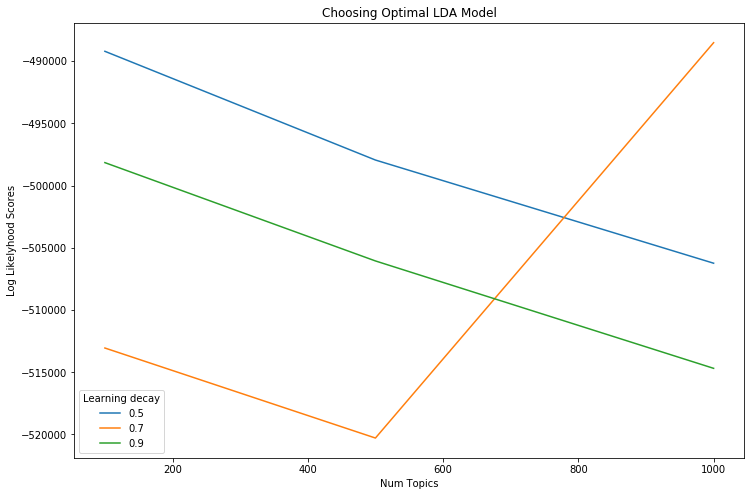

In [30]:
n_components = [100,500,1000]


log_likelyhoods_5 = list()
log_likelyhoods_7 = list()
log_likelyhoods_9 = list()
for i, param in zip(range(len(model_2.cv_results_['params'])), model_2.cv_results_['params']):
    if param['learning_decay'] == 0.5:
        log_likelyhoods_5.append(model.cv_results_['mean_test_score'][i])
    if param['learning_decay'] == 0.7:
        log_likelyhoods_7.append(model.cv_results_['mean_test_score'][i])
    if param['learning_decay'] == 0.9:
        log_likelyhoods_9.append(model.cv_results_['mean_test_score'][i])
    
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

從這裡開始就覺得我的猜測不太妙了

In [51]:
pickle.dump(model_2,open('GS_2.p','wb'))

把 model 存起來!

In [23]:
model_2 = pickle.load(open('GS_2.p','rb'))

In [52]:
best_lda_model_2 = model_2.best_estimator_
print("Best Model's Params: ", model_2.best_params_)
print("Best Log Likelihood Score: ", model_2.best_score_)
print("Model Perplexity: ", best_lda_model_2.perplexity(ver2_data))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 100, 'n_jobs': -1}
Best Log Likelihood Score:  -662014.3327928735
Model Perplexity:  4233.104042295456


In [53]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model_2, ver2_data, ver2_count, mds='tsne')
panel

D:\anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
98     0.593268  2.365408       1        1  2.198863
8      2.407392  1.733233       2        1  1.961281
78    -1.789876  0.358906       3        1  1.897164
87     2.804025  1.861566       4        1  1.822515
59    -1.013140 -1.620953       5        1  1.755714
69     0.649023  1.699423       6        1  1.642834
4      1.237648  2.985359       7        1  1.531942
5      0.161389  0.216866       8        1  1.369460
38    -0.059930  1.185345       9        1  1.356426
46    -0.574462  0.128756      10        1  1.316520
0     -0.396872  0.150523      11        1  1.297179
50     0.224007  0.560757      12        1  1.247958
34    -1.245422  2.156106      13        1  1.226679
40     0.436844  1.559386      14        1  1.217496
19    -1.640283  2.640946      15        1  1.213783
97    -2.455194  0.355009      16        1  1.209499
63    -2.557898  1.582374      17        1  1.199591
64    -0.911226  0.303272      18        1  1.181997
27     1.000692  0.835836      19        1  1.175916
23    -1.971986 -0.039853      20        1  1.155446
17     0.596490  0.757297      21        1  1.153831
28    -2.411711  1.905647      22        1  1.126810
79     0.530383  2.210653      23        1  1.126395
32    -2.488515  0.101291      24        1  1.120100
21     2.633219 -0.282438      25        1  1.116354
67     0.361870 -0.361984      26        1  1.115434
93    -0.919904  0.949378      27        1  1.109232
56    -2.111215  3.397778      28        1  1.105684
29    -0.128773 -1.847150      29        1  1.101291
96    -0.761104 -0.591624      30        1  1.077904
...         ...       ...     ...      ...       ...
55     1.569222  1.273681      71        1  0.841412
77    -2.132878  3.456296      72        1  0.819365
68    -1.374521 -0.852934      73        1  0.809181
11     0.675121 -1.396691      74        1  0.801455
25     2.073790  0.581542      75        1  0.796015
54    -2.170946 -0.362375      76        1  0.793490
89     0.790586 -0.579822      77        1  0.788224
42    -0.155381  3.191945      78        1  0.779676
47    -1.792208  3.659442      79        1  0.777690
72    -0.410464  3.786081      80        1  0.763996
92    -0.299239  2.023756      81        1  0.754811
76    -2.112586  0.514793      82        1  0.745331
14    -2.773229 -0.686237      83        1  0.744006
39     1.216426  1.327921      84        1  0.729119
53     2.930543  0.546219      85        1  0.720779
26    -1.060875  1.680472      86        1  0.710751
51     0.402884  0.256980      87        1  0.695969
1     -1.351684 -0.249526      88        1  0.689206
80     0.350497  1.444857      89        1  0.679346
41    -0.320276  1.518852      90        1  0.658503
88    -1.897968  1.157983      91        1  0.656368
18    -2.331228  1.259725      92        1  0.648149
83    -1.521291  0.597220      93        1  0.642456
74     0.228620 -1.103728      94        1  0.636052
65     1.468962 -0.246990      95        1  0.633152
45     1.366791 -0.833694      96        1  0.627883
13    -1.964671 -1.201140      97        1  0.609563
48    -0.431762 -1.341307      98        1  0.591434
2      0.973042  1.389052      99        1  0.579966
10    -0.617866  2.837204     100        1  0.552301

[100 rows x 5 columns], topic_info=      Category        Freq            Term       Total  loglift  logprob
term                                                                    
4855   Default  599.000000           video  599.000000  30.0000  30.0000
4235   Default  446.000000          speech  446.000000  29.0000  29.0000
3044   Default  351.000000          object  351.000000  28.0000  28.0000
3571   Default  387.000000           query  387.000000  27.0000  27.0000
4922   Default  498.000000             web  498.000000  26.0000  26.0000
2070   Default  372.000000           graph  372.000000  25.0000  25.0000
3335   Def

阿!這個分類結果一點用都沒有QQ
不過藉由觀察 top 30 Rank 我們知道有太多的單字是散佈在空間中了，而且是同質性非常高的單字，這樣很難分阿!

接著想做的事情是如果我把文字全部轉換成它的字根，對分類的結果會造成什麼影響呢?

In [16]:
porter = PorterStemmer()

def tokenizer_porter(text):
    return[porter.stem(word) for word in text.split()]

def tokenizer(text):
    return text.split()

def docs_preprocessor(docs):
    porter = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        #docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.
        docs[idx] = tokenizer_porter(docs[idx])
    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [17]:
docs = docs_preprocessor(data)

In [18]:
print(docs[0])

['evalu', 'similar', 'measur', 'larg', 'scale', 'studi', 'orkut', 'social', 'network', 'onlin', 'inform', 'servic', 'have', 'grown', 'larg', 'user', 'navig', 'without', 'help', 'autom', 'tool', 'such', 'collabor', 'filter', 'which', 'make', 'recommend', 'user', 'base', 'their', 'collect', 'past', 'behavior', 'while', 'mani', 'similar', 'measur', 'have', 'been', 'propos', 'individu', 'evalu', 'they', 'have', 'been', 'evalu', 'each', 'other', 'larg', 'real', 'world', 'environ', 'present', 'extens', 'empir', 'comparison', 'distinct', 'measur', 'similar', 'recommend', 'onlin', 'commun', 'member', 'orkut', 'social', 'network', 'determin', 'differ', 'recommend', 'actual', 'measur', 'user', 'propens', 'visit', 'join', 'recommend', 'commun', 'also', 'examin', 'order', 'recommend', 'influenc', 'user', 'select', 'well', 'interest', 'social', 'issu', 'that', 'aris', 'recommend', 'commun', 'within', 'real', 'social', 'network']


In [19]:
a = np.empty(shape = (2297,0))
for i in range(2297):
    g = np.array(docs[i])
    a = np.append(a,[g])
a.shape

(234386,)

In [20]:
pre3_c = CountVectorizer(stop_words='english',max_df = 0.1,min_df = 0.001,max_features=5000)
pre3_data = pre3_c.fit_transform(a)

因為我在乎的是單字的分類，所以把它全部串起來應該不會影響到分析的結果

In [22]:
search_params = {'n_components': [3,4,5,6,8,10], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, param_grid=search_params,n_jobs = -1)
model.fit(pre3_data)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [3, 4, 5, 6, 8, 10], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [24]:
pickle.dump(model,open('GS_pre3.p','wb'))

In [22]:
model = pickle.load(open('GS_pre3.p','rb'))

In [23]:
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(pre3_data))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -148290.81309339657
Model Perplexity:  160.44005500076875


這是我得到分數最好的一次 log socre 下降非常顯著 

把已經 grid search 的結果存下來不然每次都要重跑心很累。

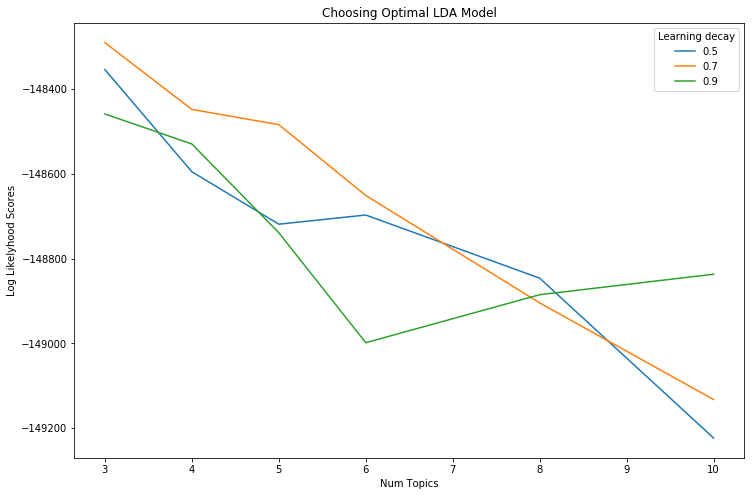

In [24]:
n_components = [3,4,5,6,8,10]
log_likelyhoods_5 = list()
log_likelyhoods_7 = list()
log_likelyhoods_9 = list()
for i, param in zip(range(len(model.cv_results_['params'])), model.cv_results_['params']):
    if param['learning_decay'] == 0.5:
        log_likelyhoods_5.append(model.cv_results_['mean_test_score'][i])
    if param['learning_decay'] == 0.7:
        log_likelyhoods_7.append(model.cv_results_['mean_test_score'][i])
    if param['learning_decay'] == 0.9:
        log_likelyhoods_9.append(model.cv_results_['mean_test_score'][i])
    
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

這個看起來效果都不太好，但 Log score 少了4 倍

In [25]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, pre3_data, pre3_c, mds='tsne')
panel

D:\anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  34.784023
0     -1209.665405  212.164124       2        1  34.469424
2     -1437.453247 -586.322510       3        1  30.746553, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
100   Default  2693.000000        model  2693.000000  30.0000  30.0000
39    Default  2024.000000         data  2024.000000  29.0000  29.0000
88    Default  1533.000000        learn  1533.000000  28.0000  28.0000
105   Default  1484.000000      network  1484.000000  27.0000  27.0000
144   Default  1255.000000       result  1255.000000  26.0000  26.0000
16    Default  1303.000000         base  1303.000000  25.0000  25.0000
12    Default  1086.000000     approach  1086.000000  24.0000  24.0000
87    Default  1072.000000         larg  1072.000000  23.0000  23.0000
6     Default  1191.000000    algorithm  1191.000000  22.0000  22.0000
178   Default  1174.000000         user  1174.000000  21.0000  21.0000
125   Default  1008.000000      problem  1008.000000  20.0000  20.0000
116   Default   987.000000        paper   987.000000  19.0000  19.0000
175   Default  1059.000000        train  1059.000000  18.0000  18.0000
98    Default  1028.000000       method  1028.000000  17.0000  17.0000
67    Default   974.000000        gener   974.000000  16.0000  16.0000
118   Default   937.000000      perform   937.000000  15.0000  15.0000
168   Default   825.000000         task   825.000000  14.0000  14.0000
123   Default   853.000000      present   853.000000  13.0000  13.0000
33    Default   852.000000       comput   852.000000  12.0000  12.0000
64    Default   733.000000       featur   733.000000  11.0000  11.0000
45    Default   731.000000       design   731.000000  10.0000  10.0000
147   Default   730.000000       search   730.000000   9.0000   9.0000
129   Default   814.000000       propos   814.000000   8.0000   8.0000
173   Default   812.000000         time   812.000000   7.0000   7.0000
78    Default   779.000000       improv   779.000000   6.0000   6.0000
130   Default   773.000000       provid   773.000000   5.0000   5.0000
49    Default   687.000000       differ   687.000000   4.0000   4.0000
114   Default   726.000000        optim   726.000000   3.0000   3.0000
75    Default   708.000000         imag   708.000000   2.0000   2.0000
146   Default   685.000000        scale   685.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
39     Topic3  2023.902995         data  2024.547741   1.1791  -2.5790
144    Topic3  1254.999937       result  1255.644684   1.1789  -3.0569
12     Topic3  1086.189776     approach  1086.834523   1.1788  -3.2014
87     Topic3  1072.031505         larg  1072.676251   1.1788  -3.2145
125    Topic3  1007.774733      problem  1008.419480   1.1788  -3.2763
116    Topic3   987.081875        paper   987.726622   1.1787  -3.2970
168    Topic3   824.806300         task   825.451047   1.1786  -3.4766
64     Topic3   733.322084       featur   733.966831   1.1785  -3.5942
45     Topic3   731.143888       design   731.788635   1.1785  -3.5972
147    Topic3   730.054790       search   730.699538   1.1785  -3.5987
49     Topic3   686.490878       differ   687.135625   1.1785  -3.6602
92     Topic3   550.353651       machin   550.998398   1.1782  -3.8812
54     Topic3   529.660792       effect   530.305540   1.1782  -3.9195
44     Topic3   496.987858      describ   497.632605   1.1781  -3.9832
71     Topic3   495.898760         high   496.543507   1.1781  -3.9854
132    Topic3   438.176575        queri   438.821323   1.1779  -4.1092
95     Topic3   420.751010       measur   421.395758   1.1779  -4.1497
111    Topic3   420.751010         onli   421.395758   1.1779  -4.1497
70     Topic3   416.394619        graph  

這個 model 分類的結果真的不錯，在 top 30 model 就是一個泡泡對應一個詞彙，我還蠻喜歡這種 model 的，所以我想要看看裡面組成的單字有甚麼。

In [26]:
top_words = 10
feature_token = pre3_c.get_feature_names()
for topic_idx, topic in enumerate(best_lda_model.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ,".join([feature_token[i] for i in topic.argsort()[:-top_words - 1 : -1]]))

Topic 1:
network ,train ,method ,perform ,present ,comput ,improv ,provid ,scale ,applic
Topic 2:
model ,learn ,base ,algorithm ,user ,gener ,propos ,time ,optim ,imag
Topic 3:
data ,result ,approach ,larg ,problem ,paper ,task ,featur ,design ,search


我個人猜測是因為 google AI research 裡面的字非常相近，所以才會發現 3 個 topic 在講的事情很像，彼此關聯性很高，所以才會讓 log score 居高不下。但是這個結果還是很奇怪，所以我覺得我應該要把文章還原成 2297 個字根字串組成的資料，才是正確的策略。

In [27]:
matrixdata = []
for i in docs:
    strbuf = ''
    for j in i:
        #print(j)
        strbuf += j 
        strbuf += ' '
    matrixdata.append(strbuf)

In [28]:
npma = np.array(matrixdata)
pre4_c = CountVectorizer(stop_words='english',max_df = 0.1,min_df = 0.001,max_features=5000)
pre4_data = pre4_c.fit_transform(npma)

In [29]:
search_params = {'n_components': [3,4,5,6], 'learning_decay': [.5, .7, .9]}
lda = LatentDirichletAllocation()
model_4 = GridSearchCV(lda, param_grid=search_params,n_jobs = -1)
model_4.fit(pre4_data)

D:\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_components': [3, 4, 5, 6], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [30]:
best_lda_model_4 = model_4.best_estimator_
print("Best Model's Params: ", model_4.best_params_)
print("Best Log Likelihood Score: ", model_4.best_score_)
print("Model Perplexity: ", best_lda_model_4.perplexity(pre4_data))
pickle.dump(model_4,open('GS_pre4.p','wb'))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -338503.18553010264
Model Perplexity:  1495.307144806064


不妙!!!

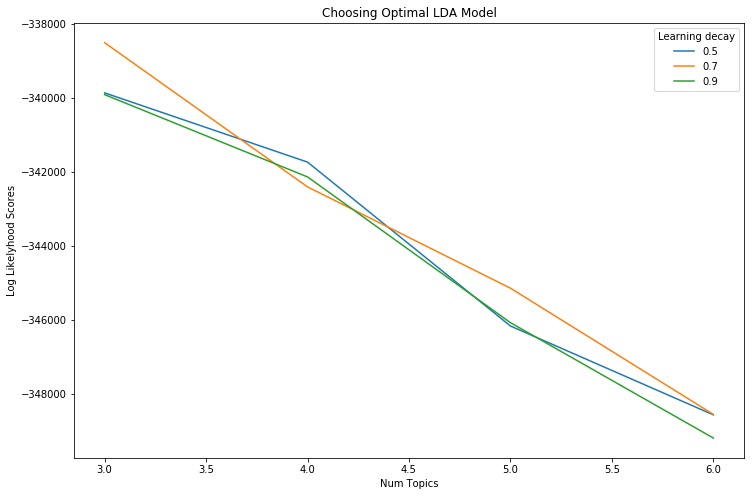

In [31]:
n_components = [3,4,5,6]
log_likelyhoods_5 = list()
log_likelyhoods_7 = list()
log_likelyhoods_9 = list()
for i, param in zip(range(len(model_4.cv_results_['params'])), model_4.cv_results_['params']):
    if param['learning_decay'] == 0.5:
        log_likelyhoods_5.append(model_4.cv_results_['mean_test_score'][i])
    if param['learning_decay'] == 0.7:
        log_likelyhoods_7.append(model_4.cv_results_['mean_test_score'][i])
    if param['learning_decay'] == 0.9:
        log_likelyhoods_9.append(model_4.cv_results_['mean_test_score'][i])
    
plt.figure(figsize=(12, 8))
plt.plot(n_components, log_likelyhoods_5, label='0.5')
plt.plot(n_components, log_likelyhoods_7, label='0.7')
plt.plot(n_components, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.show()

In [32]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model_4, pre4_data, pre4_c, mds='tsne')
panel

D:\anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                 x           y  topics  cluster       Freq
topic                                                     
1      -632.045471 -384.325073       1        1  39.475312
0     -1209.665405  212.164124       2        1  34.737013
2     -1437.453247 -586.322510       3        1  25.787674, topic_info=     Category        Freq       Term       Total  loglift  logprob
term                                                              
2285  Default  385.000000      queri  385.000000  30.0000  30.0000
2705  Default  439.000000     speech  439.000000  29.0000  29.0000
1250  Default  367.000000      graph  367.000000  28.0000  28.0000
3188  Default  591.000000      video  591.000000  27.0000  27.0000
2548  Default  262.000000      secur  262.000000  26.0000  26.0000
2335  Default  364.000000   recognit  364.000000  25.0000  25.0000
2579  Default  349.000000     servic  349.000000  24.0000  24.0000
2666  Default  265.000000    softwar  265.000000  23.0000  23.0000
2848  Default  229.000000     survey  229.000000  22.0000  22.0000
777   Default  300.000000      devic  300.000000  21.0000  21.0000
478   Default  287.000000    cluster  287.000000  20.0000  20.0000
59    Default  297.000000   advertis  297.000000  19.0000  19.0000
2337  Default  176.000000  recommend  176.000000  18.0000  18.0000
2207  Default  197.000000    privaci  197.000000  17.0000  17.0000
1001  Default  178.000000      event  178.000000  16.0000  16.0000
1800  Default  271.000000      mobil  271.000000  15.0000  15.0000
2304  Default  178.000000       rank  178.000000  14.0000  14.0000
2573  Default  389.000000    sequenc  389.000000  13.0000  13.0000
198   Default  141.000000   attribut  141.000000  12.0000  12.0000
315   Default  234.000000      bound  234.000000  11.0000  11.0000
2660  Default  223.000000     social  223.000000  10.0000  10.0000
29    Default  181.000000     acoust  181.000000   9.0000   9.0000
464   Default  115.000000      click  115.000000   8.0000   8.0000
963   Default  115.000000     entiti  115.000000   7.0000   7.0000
146   Default  323.000000   approxim  323.000000   6.0000   6.0000
611   Default  316.000000    control  316.000000   5.0000   5.0000
2969  Default  270.000000       tool  270.000000   4.0000   4.0000
1860  Default  111.000000      music  111.000000   3.0000   3.0000
199   Default  156.000000    auction  156.000000   2.0000   2.0000
58    Default  155.000000  adversari  155.000000   1.0000   1.0000
...       ...         ...        ...         ...      ...      ...
1736   Topic3  127.363350     medium  157.715786   1.1415  -5.5894
478    Topic3  216.095314    cluster  287.148040   1.0710  -5.0607
59     Topic3  220.227383   advertis  297.843141   1.0534  -5.0418
695    Topic3   88.227351    databas  106.706904   1.1651  -5.9565
2660   Topic3  164.709330     social  223.479631   1.0501  -5.3323
2972   Topic3  122.971167      topic  161.739214   1.0812  -5.6245
1428   Topic3   46.723726      index   53.775066   1.2147  -6.5922
1261   Topic3  119.191478      group  174.582158   0.9736  -5.6557
659    Topic3   59.268570    coverag   73.085129   1.1457  -6.3544
1602   Topic3   68.535817     latent   88.599305   1.0985  -6.2091
123    Topic3  139.762502      annot  231.030378   0.8527  -5.4965
2515   Topic3  109.499863    scalabl  172.920393   0.8984  -5.7405
33     Topic3  129.122015      activ  223.523066   0.8065  -5.5757
769    Topic3  147.738907     detect  275.169659   0.7333  -5.4410
1744   Topic3  149.538491     memori  281.053212   0.7243  -5.4289
1070   Topic3  122.546961     factor  210.987601   0.8120  -5.6280
1058   Topic3  108.578493    extract  177.899367   0.8615  -5.7490
2573   Topic3  175.318186    sequenc  389.576759   0.5568  -5.2699
1901   Topic3   99.822337       node  156.578895   0.9051  -5.8331
2555   Topic3  131.884990     select  253.009808   0.7038  -5.5545
2026   Topic3   98.531353   parallel  154.566112   0.9050  -5.8461
1657   Topic3  128.224002      local  281.58

抱歉，上面的猜測是錯誤的，實際上將 data 還原成文章字串的 list 後分出來的結果是大相逕庭的!
也是拉如果把它變成一維，就等於是讓文章的訊息失真成全部同一篇文章，會遺失掉資訊，所以才能分成這樣子吧!遺憾...

In [34]:
top_words = 10
feature_token = pre4_c.get_feature_names()
for topic_idx, topic in enumerate(best_lda_model_4.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ,".join([feature_token[i] for i in topic.argsort()[:-top_words - 1 : -1]]))

Topic 1:
servic ,devic ,secur ,softwar ,control ,mobil ,survey ,program ,tool ,interact
Topic 2:
video ,speech ,recognit ,object ,estim ,input ,sampl ,word ,architectur ,paramet
Topic 3:
queri ,graph ,advertis ,cluster ,sequenc ,recommend ,event ,social ,rank ,memori


我發現分類的效果比起不做字根好多了耶!
尤其是在主題 2 speech , word , recognit 會直接讓我聯想到 rnn 或是語音辨識
而主題 1 和主題 3 也不會說完全沒有關聯，分類的結果也和全部當成一維的結果不一樣，不會把 model network 之類的推得乾乾淨淨的，這個 lda model 大概就差在 video 重複了吧!
<br />我認為:<br /> 
主題 1 : 跟軟體有關的東西<br /> 
主題 2 : 語音辨識，語音處理<br /> 
主題 3 : 演算法 <br /> 

<h1>Cluster</h1>

先拿沒有經過字根處理的 data 試試看。

In [54]:
ver2_data.shape

(2297, 5000)

In [19]:
    #nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aspy1\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

2 Clusters score =  0.5431214910857464
3 Clusters score =  0.5297793750034084
4 Clusters score =  0.08281763262918117
5 Clusters score =  0.5030013233454105
6 Clusters score =  0.5101650194034304
7 Clusters score =  0.5116094615024817
8 Clusters score =  0.5696633170182814
9 Clusters score =  0.31830041466470155
10 Clusters score =  0.16155400513856624
11 Clusters score =  0.1614956010004832
12 Clusters score =  0.16176033790269362
13 Clusters score =  0.5048092868679223
14 Clusters score =  0.5051716115212412


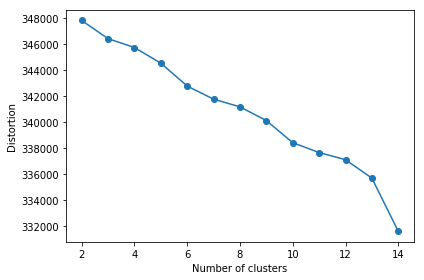

In [55]:
    from sklearn.metrics import silhouette_score
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(ver2_data.T)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(ver2_data.T, y_km, metric='euclidean'))

    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

Distortion looks really unfriendly

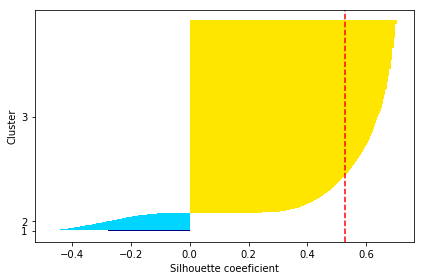

In [225]:
    from sklearn.metrics import silhouette_samples
    km = KMeans(n_clusters=3,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(ver2_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ver2_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()

In [227]:
    words = ver2_count.get_feature_names()
    silhouette_vals = silhouette_samples(ver2_data.T, y_km, metric='euclidean')
    for n in range(N):
        val = []
        index = []
        for i,a in enumerate(y_ac):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)
        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(10):
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

Topic  0
2230
['definite', 'develop', 'disadvantage', 'current', 'administration', 'date', 'designer', 'displayed', 'adjacent', 'displaying']
Topic  1
8
['contribute', 'bayesian', 'incurs', 'bigtable', 'identifying', 'complete', 'biological', 'contrasting']
Topic  2
6
['administrator', 'allocated', 'degradation', 'bilinear', 'independence', 'airline']


雖然從圖就知道分得很爛了，實際上去 print 出來還真的蠻爛的。

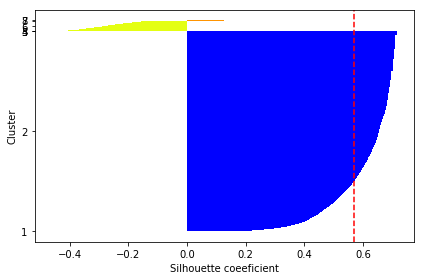

In [57]:
    km = KMeans(n_clusters=8,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(ver2_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ver2_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()    

如果我把 count vector 改成要數前後三個字，會對我的 cluster 有幫助嗎?

In [61]:
    my_count_2 = LemmaCountVectorizer(max_df=0.2, 
                                min_df=0.001,
                                stop_words='english',
                                max_features=5000,ngram_range=(3, 3))
    my_data_2 = my_count.fit_transform(ver1pre)

2 Clusters score =  0.5431214910857464
3 Clusters score =  0.5297793750034084
4 Clusters score =  0.08281763262918117
5 Clusters score =  0.5030013233454105
6 Clusters score =  0.5101650194034304
7 Clusters score =  0.5116094615024817
8 Clusters score =  0.5696633170182814
9 Clusters score =  0.31830041466470155
10 Clusters score =  0.16155400513856624
11 Clusters score =  0.1614956010004832


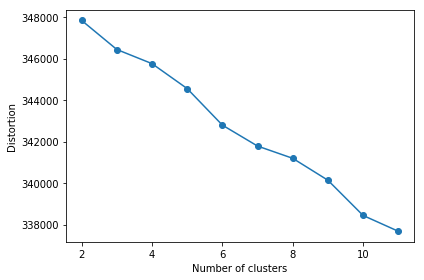

In [62]:
    distortions = []
    for i in range(2,12):
        km = KMeans(n_clusters=i,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(my_data_2.T)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(my_data_2.T, y_km, metric='euclidean'))
    plt.plot(range(2, 12), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

7 is elbow point and 3 has the highest cluster score just as same as above and distortion looks unchanged

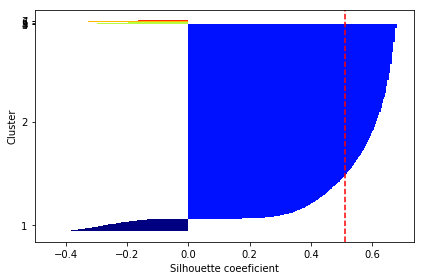

In [63]:
    km = KMeans(n_clusters=7,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(my_data_2.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(my_data_2.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

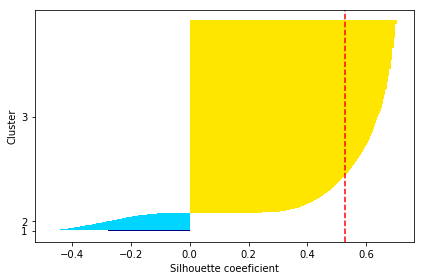

In [64]:
    km = KMeans(n_clusters=3,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(my_data_2.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(my_data_2.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

分的很糟糕，仔細想一想，即使我 n_pram 設定不同，但是他的表達是仍然是矩陣，所以字與字之間並不會有前後關係，因為不像 RNN 那樣有 feed back ，<br />
而且彼此之間也是獨立的 component ，所以做這個分析很可能是沒有意義的，除非可以把他轉成 rnn 或是用 word2vec 做 preprocess。<br />
不過用 word2vec 就有點作弊了，因為它本質上是採用 DL 的方法去計算出每個字和字之間的距離，但是這確實可以讓 model 分得更好，因為現在的 model 其實是很糟糕的<br />
，每個字和每個字的關聯性並不是獨立的或是相同的。

試試看另外一種，只用字根的 data

2 Clusters score =  0.5303671323413908
3 Clusters score =  0.5335354808606905
4 Clusters score =  0.3920215328311122
5 Clusters score =  0.39380145371687786
6 Clusters score =  0.3951478309879927
7 Clusters score =  0.47324559540592864
8 Clusters score =  0.4724944835331131
9 Clusters score =  0.4725407029384414
10 Clusters score =  0.47296356047503424
11 Clusters score =  0.4736162559259806
12 Clusters score =  0.34204769810264846
13 Clusters score =  0.3421081755127844
14 Clusters score =  0.3423131139273394


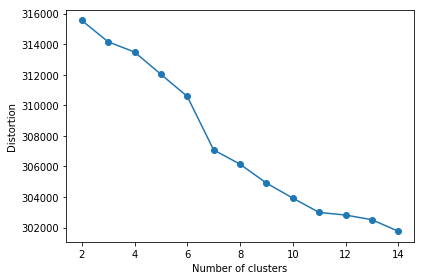

In [65]:
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(pre4_data.T)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(pre4_data.T, y_km, metric='euclidean'))

    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

由這張圖我覺得用字根效果比較好，但是沒有非常顯著，不過 distortion 確實下降了，而且也有比較明顯的 elbow。

3 和 7 吧，看起來都像 elboe point

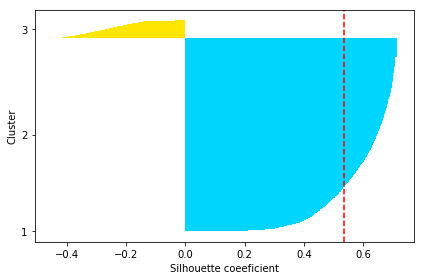

In [66]:
    km = KMeans(n_clusters=3,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(pre4_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

阿!所以還是和其他 model 一樣，會有一個 topic 主導其他的 node ，所以這次分不好的主因應該就是這個了，因為有一些詞彙重復出現<br />
在各個資料中，所以我們的 model 其中一個 cluster 看到這些字就想把他抓進自己的類別，然而這樣會導致某一個 cluster 看到這些詞<br />
彙的出現就覺得它應該被歸類在我的 cluster 內。

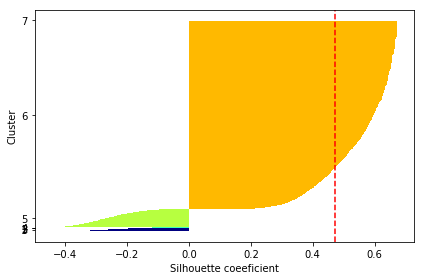

In [67]:
    km = KMeans(n_clusters=7,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(pre4_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

<h1>K-means++</h1>

2 Clusters score =  0.5773283198877127
3 Clusters score =  0.7871484182071279
4 Clusters score =  0.5750657861913517
5 Clusters score =  0.5700481339641841
6 Clusters score =  0.5723067378238007
7 Clusters score =  0.5700026559644787
8 Clusters score =  0.5262563035383521
9 Clusters score =  0.47264967210383463
10 Clusters score =  0.4500250827175072
11 Clusters score =  0.5128766225748946
12 Clusters score =  0.4642571952979323
13 Clusters score =  0.5426768041868026
14 Clusters score =  0.5393728884519875


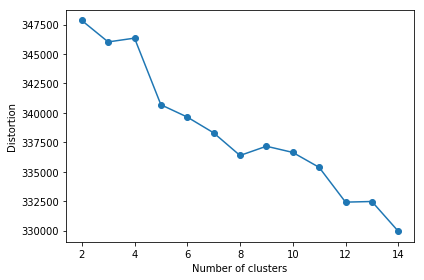

In [68]:
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(ver2_data.T)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(ver2_data.T, y_km, metric='euclidean'))
    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

I'll take 11 as elbow points and I think 12 has nice cluster score

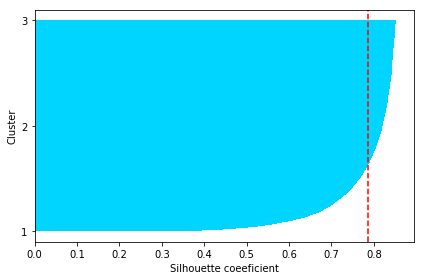

In [74]:
    km = KMeans(n_clusters=3,
                    init='k-means++',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(ver2_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ver2_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

這個可能就是 kmeans++ 中最好的 model 了，因為至少它的分類沒有負的 coefficient

用 silhouette_vals 跑看看裡面的 topic words 好了

In [77]:
words = ver2_count.get_feature_names()
for n in range(3):
    val = []
    index = []
    for i,a in enumerate(y_km):
        if a == n:
            val.append(silhouette_vals[i])
            index.append(i)

    sort = np.argsort(-np.array(val))
    print('Topic ', n )
    print('Topic words :',len(index))
    buf = []
    for i in range(10):
        if i < len(index):
            buf.append(words[index[sort[i]]])
    print(buf)

Topic  0
Topic words : 1
['video']
Topic  1
Topic words : 4998
['underestimated', 'undertaking', '68', 'disagree', 'uninteresting', '05', 'diagnostic', 'writes', 'curvature', '79']
Topic  2
Topic words : 1
['query']


好吧，還是分得不太好!

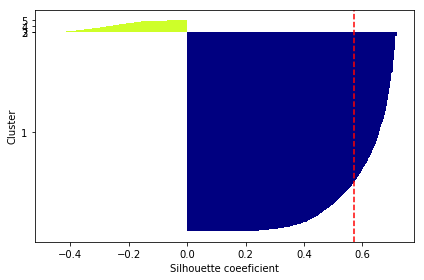

In [71]:
    km = KMeans(n_clusters=5,
                    init='k-means++',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(ver2_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ver2_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

2 Clusters score =  0.8280693438317455
3 Clusters score =  0.5335187299047431
4 Clusters score =  0.5305831314490926
5 Clusters score =  0.45654797494948113
6 Clusters score =  0.5291337200785206
7 Clusters score =  0.5426133784627931
8 Clusters score =  0.5399662314404916
9 Clusters score =  0.5138391783617334
10 Clusters score =  0.5374380130894093
11 Clusters score =  0.5290129308947739
12 Clusters score =  0.4498582051849218
13 Clusters score =  0.5233271093488867
14 Clusters score =  0.45988933097166673


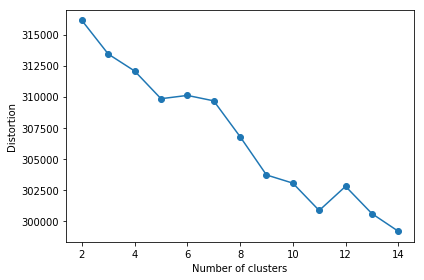

In [73]:
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,
                    init='k-means++',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(pre4_data.T)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(pre4_data.T, y_km, metric='euclidean'))
    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

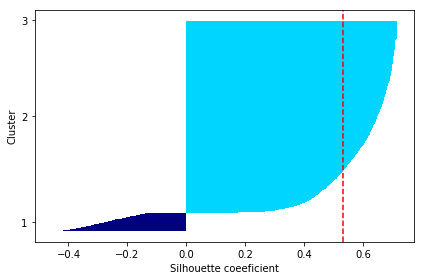

In [82]:
    km = KMeans(n_clusters=3,
                    init='k-means++',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(pre4_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

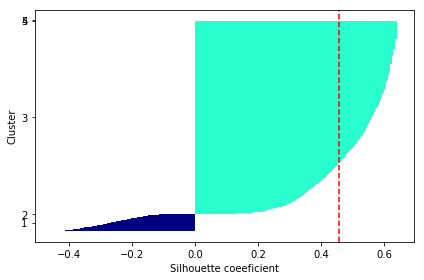

In [81]:
    km = KMeans(n_clusters=5,
                    init='k-means++',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
    y_km = km.fit_predict(pre4_data.T)
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

恩...沒想到用字根來分效果也不太好，可能這個 data 不太適合用 center 找 edge point吧!

<h1>Agglomerative (with Hierarchical Clustering)</h1>

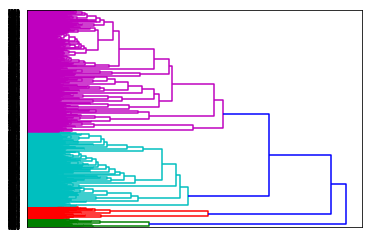

<Figure size 432x288 with 0 Axes>

In [80]:
    from sklearn.metrics.pairwise import cosine_similarity
    dist = 1 - cosine_similarity(ver2_data)
    from scipy.cluster.hierarchy import ward, dendrogram
    from sklearn.metrics.pairwise import cosine_distances
    from sklearn.cluster import AgglomerativeClustering

    linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

    ax = dendrogram(linkage_matrix, orientation="right");

    plt.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    #plt.tight_layout() #show plot with tight layout
    plt.show()
    plt.savefig('ward_clusters.png', dpi=300)

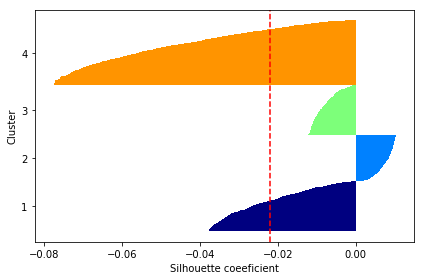

In [104]:
ac = AgglomerativeClustering(n_clusters=4,affinity=cosine_similarity,linkage='complete')
y_km = ac.fit_predict(pre4_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='euclidean')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

In [105]:
words = ver2_count.get_feature_names()
for n in range(4):
    val = []
    index = []
    for i,a in enumerate(y_km):
        if a == n:
            val.append(silhouette_vals[i])
            index.append(i)

    sort = np.argsort(-np.array(val))
    print('Topic ', n )
    print('Topic words :',len(index))
    buf = []
    for i in range(10):
        if i < len(index):
            buf.append(words[index[sort[i]]])
    print(buf)

Topic  0
Topic words : 781
['lower', 'draw', 'auction', 'choosing', 'identical', 'higher', 'hybrid', 'person', 'adaptation', 'lay']
Topic  1
Topic words : 723
['conduct', 'debug', 'crucially', '2013', 'compilation', 'fi', 'gas', 'past', 'anomaly', 'arises']
Topic  2
Topic words : 782
['larger', 'connecting', 'control', 'iteration', 'freebase', 'accelerated', 'haptic', 'conservative', 'labeled', 'latent']
Topic  3
Topic words : 1014
['form', 'definite', 'conflicting', '300', 'collective', 'induced', 'mini', 'knapsack', 'augment', 'id']


應該把數字去掉的這樣看起來很奇怪!因為數字看不出關聯性!

In [115]:
e_num = ver1pre.tolist()
e_num = [re.sub('[^a-zA-Z]', ' ', i) for i in e_num]
print(e_num[0])
e_num_np = np.array(e_num)
print(e_num_np.shape)
enum_data = ver2_count.fit_transform(e_num_np)

Evaluating similarity measures  a large scale study in the orkut social network  Online information services have grown too large for users to navigate without the help of automated tools such as collaborative filtering  which makes recommendations to users based on their collective past behavior  While many similarity measures have been proposed and individually evaluated  they have not been evaluated relative to each other in a large real world environment  We present an extensive empirical comparison of six distinct measures of similarity for recommending online communities to members of the Orkut social network  We determine the usefulness of the different recommendations by actually measuring users  propensity to visit and join recommended communities  We also examine how the ordering of recommendations influenced user selection  as well as interesting social issues that arise in recommending communities within a real social network 
(2297,)


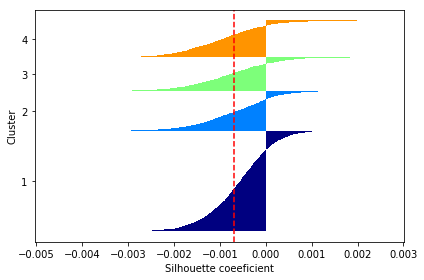

In [126]:
ac = AgglomerativeClustering(n_clusters=4,affinity=cosine_similarity,linkage='complete')
y_km = ac.fit_predict(enum_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(enum_data.toarray().T, y_km, metric='cosine')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

In [127]:
words = ver2_count.get_feature_names()
for n in range(4):
    val = []
    index = []
    for i,a in enumerate(y_km):
        if a == n:
            val.append(silhouette_vals[i])
            index.append(i)

    sort = np.argsort(-np.array(val))
    print('Topic ', n )
    print('Topic words :',len(index))
    buf = []
    for i in range(10):
        if i < len(index):
            buf.append(words[index[sort[i]]])
    print(buf)

Topic  0
Topic words : 2383
['optimally', 'start', 'reveal', 'digit', 'dataset', 'intervention', 'warm', 'exception', 'adult', 'validity']
Topic  1
Topic words : 945
['node', 'kleinberg', 'mini', 'feedforward', 'smaller', 'suited', 'optimizes', 'refer', 'problematic', 'actually']
Topic  2
Topic words : 794
['combined', 'apps', 'variable', 'ptas', 'group', 'sourced', 'fusing', 'connect', 'retrieve', 'involved']
Topic  3
Topic words : 878
['reaction', 'advantageous', 'clinching', 'lds', 'overly', 'discrepancy', 'surveillance', 'later', 'traditionally', 'crucial']


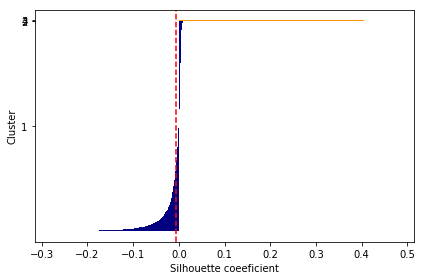

In [125]:
ac = AgglomerativeClustering(n_clusters=4,affinity=cosine_distances,linkage='complete')
y_km = ac.fit_predict(enum_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(enum_data.toarray().T, y_km,metric = 'cosine')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

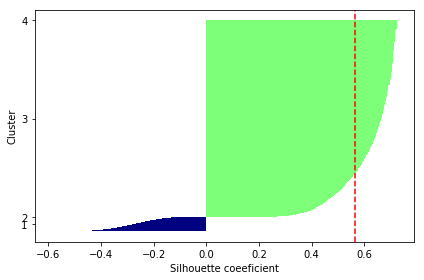

In [129]:
ac = AgglomerativeClustering(n_clusters=4,affinity='euclidean',linkage='ward')
y_km = ac.fit_predict(enum_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(enum_data.toarray().T, y_km, metric='euclidean')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

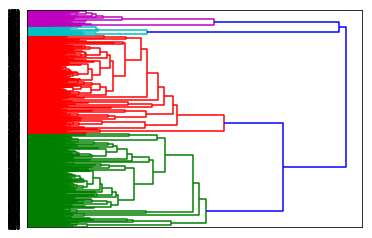

<Figure size 432x288 with 0 Axes>

In [92]:
dist = 1 - cosine_similarity(pre4_data)
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances
ax = dendrogram(linkage_matrix, orientation="right");
plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)

    #plt.tight_layout() #show plot with tight layout
plt.show()
plt.savefig('ward_clusters.png', dpi=300)

這個看起來可以分成4類喔!!

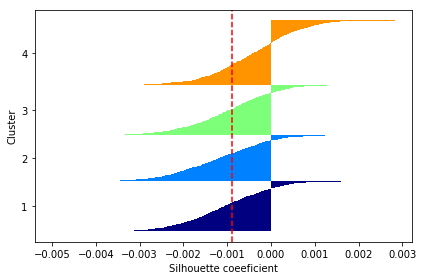

In [130]:
ac = AgglomerativeClustering(n_clusters=4,affinity=cosine_similarity,linkage='complete')
y_km = ac.fit_predict(pre4_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='cosine')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

這個圖非常有意思，因為我們的圖中四個 cluster 的形狀都長得非常類似，但是每個群中卻都包含著負的與正的。
如果它都是往右長就好了呢!

In [132]:
words = pre4_c.get_feature_names()
for n in range(4):
    val = []
    index = []
    for i,a in enumerate(y_km):
        if a == n:
            val.append(silhouette_vals[i])
            index.append(i)

    sort = np.argsort(-np.array(val))
    print('Topic ', n )
    print('Topic words :',len(index))
    buf = []
    for i in range(10):
        if i < len(index):
            buf.append(words[index[sort[i]]])
    print(buf)

Topic  0
Topic words : 781
['allevi', 'soon', 'blur', 'incentiv', 'companion', 'exemplifi', 'confirm', 'basin', 'paid', 'multiag']
Topic  1
Topic words : 723
['conflict', 'forum', 'fewer', 'london', 'cours', 'ieee', 'decod', 'leakag', 'bilinear', 'student']
Topic  2
Topic words : 782
['attempt', 'insecur', 'gateway', 'burst', 'assumpt', 'denois', 'diabet', 'basi', 'default', 'care']
Topic  3
Topic words : 1014
['appropri', 'error', 'output', 'obtain', 'comparison', 'architectur', 'spend', 'behavior', 'wherea', 'integr']


從角度上來看的話我把它分成 4 類。不過因為 data 裡面都是字根，所以在分析 topic words 會比較困頓。沒有辦法像 LDA 依樣非常的直觀去說那些單字可能和什麼東西非常有關。

第一次看到這樣子的圖，雖然是負的，但是它不是被一個 topic 主導耶!
這比較有分出來的感覺

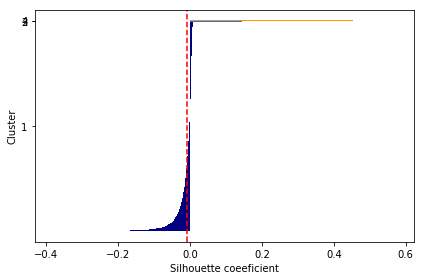

In [133]:
ac = AgglomerativeClustering(n_clusters=4,affinity=cosine_distances,linkage='complete')
y_km = ac.fit_predict(pre4_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='cosine')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

In [134]:
words = pre4_c.get_feature_names()
for n in range(4):
    val = []
    index = []
    for i,a in enumerate(y_km):
        if a == n:
            val.append(silhouette_vals[i])
            index.append(i)

    sort = np.argsort(-np.array(val))
    print('Topic ', n )
    print(len(index))
    buf = []
    for i in range(10):
        if i < len(index):
            buf.append(words[index[sort[i]]])
    print(buf)

Topic  0
3283
['obtain', 'offer', 'popul', 'assumpt', 'modern', 'recurr', 'short', 'manipul', 'accuraci', 'respond']
Topic  1
4
['geograph', 'zoom', 'play', 'role']
Topic  2
5
['rssac', 'zone', 'root', 'begun', 'defin']
Topic  3
8
['pole', 'cascad', 'cochlear', 'zero', 'copyright', 'pzfc', 'wave', 'filter']


In [135]:
ac = AgglomerativeClustering(n_clusters=4,affinity="euclidean",linkage='ward')
y_km = ac.fit_predict(pre4_data.toarray().T)

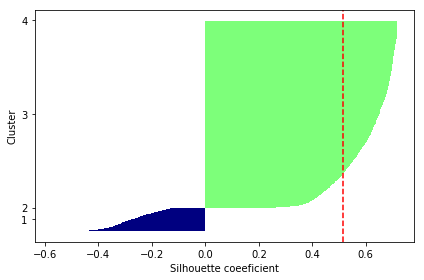

In [136]:
ac = AgglomerativeClustering(n_clusters=4,affinity="euclidean",linkage='ward')
y_km = ac.fit_predict(pre4_data.toarray().T)
cluster_labels = np.unique(y_km)
y_ax_lower, y_ax_upper = 0, 0
yticks = []
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(pre4_data.T, y_km, metric='euclidean')

for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
    
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coeeficient')
plt.tight_layout()
plt.show()  

In [88]:
ac = AgglomerativeClustering(n_clusters=4,affinity=cosine_distances,linkage='complete')
y_km = ac.fit_predict(pre4_data.toarray().T)

In [137]:
words = pre4_c.get_feature_names()
for n in range(4):
    val = []
    index = []
    for i,a in enumerate(y_km):
        if a == n:
            val.append(silhouette_vals[i])
            index.append(i)

    sort = np.argsort(-np.array(val))
    print('Topic ', n )
    print(len(index))
    buf = []
    for i in range(10):
        if i < len(index):
            buf.append(words[index[sort[i]]])
    print(buf)

Topic  0
368
['sequenc', 'queri', 'onlin', 'speech', 'advertis', 'servic', 'cluster', 'error', 'survey', 'estim']
Topic  1
3
['object', 'graph', 'label']
Topic  2
2928
['commodit', 'blacklist', 'expedit', 'exert', 'workforc', 'visitor', 'forum', 'underpin', 'centr', 'sizeabl']
Topic  3
1
['video']


我覺得 Topic 1 算是有分出來的， speech sequence 等

<h1>FCM</h1>

In [139]:
import skfuzzy as fuzz

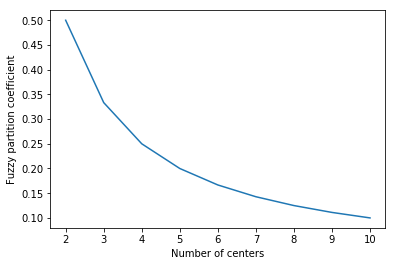

In [158]:
fpcs = []
for i in range(2,11):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(enum_data.T.toarray(), i, 2, error=0.005, maxiter=1000, init=None)
    fpcs.append(fpc)
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")
words = pre4_c.get_feature_names()

In [159]:
cntr, u_chos, _, _, _, _, _ = fuzz.cluster.cmeans(enum_data.T.toarray(), 4, 2, error=0.000005, maxiter=1000)
print(cntr.shape)
print(u_chos.shape)

(4, 5000)
(4, 2297)


In [160]:
print(u_chos)

[[0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]


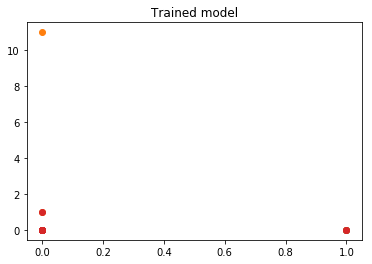

In [163]:
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(4):
    ax2.plot(enum_data.T.toarray()[0, u_chos.argmax(axis=0) == j],
             enum_data.T.toarray()[1, u_chos.argmax(axis=0) == j], 'o',
             label='series ' + str(j))

好糟糕喔

In [162]:
fpcs = []
for i in range(2,11):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(pre4_data.T.toarray(), i, 2, error=0.005, maxiter=1000, init=None)
    fpcs.append(fpc)

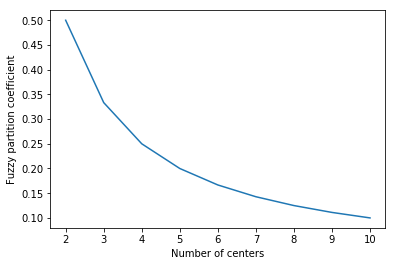

In [149]:
fig2, ax2 = plt.subplots()
ax2.plot(np.r_[2:11], fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")
words = pre4_c.get_feature_names()

In [150]:
cntr, u_chos, _, _, _, _, _ = fuzz.cluster.cmeans(pre4_data.T.toarray(), 4, 2, error=0.000005, maxiter=1000)
print(cntr.shape)
print(u_chos.shape)

(4, 3300)
(4, 2297)


In [ ]:
fig1, axes1 = plt.subplots(3, 3, figsize=(8, 8))
alldata = np.vstack((xpts, ypts))
fpcs = []

for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        alldata, ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts[cluster_membership == j],
                ypts[cluster_membership == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'rs')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    ax.axis('off')

fig1.tight_layout()

In [151]:
print(cntr)

[[0.00130605 0.0026121  0.00130605 ... 0.02829778 0.01044841 0.0017414 ]
 [0.00130605 0.0026121  0.00130605 ... 0.02829778 0.01044841 0.0017414 ]
 [0.00130605 0.0026121  0.00130605 ... 0.02829778 0.01044841 0.0017414 ]
 [0.00130605 0.0026121  0.00130605 ... 0.02829777 0.01044841 0.0017414 ]]


In [152]:
print(u_chos)

[[0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]
 [0.25 0.25 0.25 ... 0.25 0.25 0.25]]


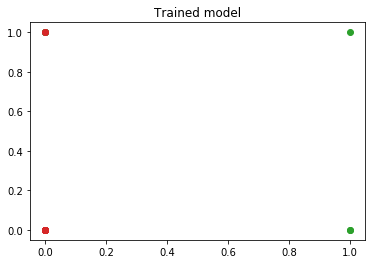

In [164]:
fig2, ax2 = plt.subplots()
ax2.set_title('Trained model')
for j in range(4):
    ax2.plot(pre4_data.T.toarray()[0, u_chos.argmax(axis=0) == j],
             pre4_data.T.toarray()[1, u_chos.argmax(axis=0) == j], 'o',
             label='series ' + str(j))

.......
這完全沒用

<h1>Document cluster </h1>

In [199]:
def kmsilhouette(n_clus , clus,algo):
    if algo == 0:
        km = KMeans(n_clusters=3,init='random',n_init=10,max_iter=400,tol=1e-04,random_state=0)
        y_km = km.fit_predict(clus)
    elif algo == 1:
        km = KMeans(n_clusters=3,init='k-means++',n_init=10,max_iter=400,tol=1e-04,random_state=0)
        y_km = km.fit_predict(clus)
    silhouette_vals = silhouette_samples(clus, y_km, metric='euclidean')
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()
    return y_km

In [195]:
def show_topic(N_top,N_clus,m_in,count, algo):
    if algo == 0 :
        km = KMeans(n_clusters=N_clus,init='random',n_init=10,max_iter=400,tol=1e-04,random_state=0)
        y = km.fit_predict(m_in)
    elif algo == 1:
        km = KMeans(n_clusters=N_clus,init='k-means++',n_init=10,max_iter=400,tol=1e-04,random_state=0)
        y = km.fit_predict(m_in)
    words = count.get_feature_names()
    silhouette_vals = silhouette_samples(m_in,y, metric='euclidean')
    for n in range(N_clus):
        val = []
        index = []
        for i,a in enumerate(y):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)
        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(N_top):
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

每次都要貼上好麻煩，乾脆把它包起來。

<h1>K-means</h1>

2 Clusters score =  0.1305956500078107
3 Clusters score =  0.0921711516736121
4 Clusters score =  0.12519813321988088
5 Clusters score =  0.08712733054528482
6 Clusters score =  0.030037874336141725
7 Clusters score =  0.024002616958944963
8 Clusters score =  0.022560318218745316
9 Clusters score =  0.022543369604995752
10 Clusters score =  0.009172485473486355
11 Clusters score =  0.009922538919612736
12 Clusters score =  0.01748362420032122
13 Clusters score =  0.024145849361320696
14 Clusters score =  0.022604126660769098


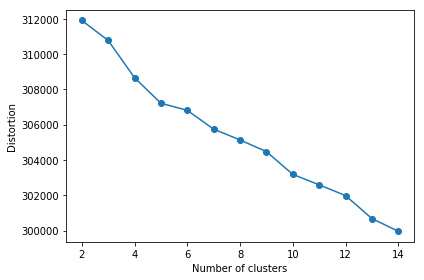

In [175]:
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(pre4_data)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(enum_data, y_km, metric='euclidean'))

    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

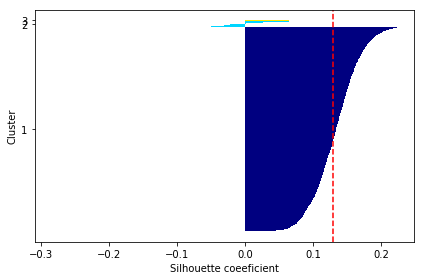

In [200]:
y_r = kmsilhouette(4,enum_data,0)

In [196]:
show_topic(10,4,enum_data,ver2_count,0)

Topic  0
35
['defend', 'dis', 'decide', 'don', 'brand', 'gate', 'database', 'human', 'hosting', 'hub']
Topic  1
183
['expressiveness', 'external', 'dropping', 'handling', 'construction', 'calculated', 'conjecture', 'distilling', 'brief', 'diameter']
Topic  2
2002
['gans', 'accounting', 'consent', 'firewall', 'aggregate', 'concerned', 'asymptotically', 'definition', 'closing', 'adaboost']
Topic  3
77
['final', 'autoregressive', 'answered', 'biology', 'discretization', 'compare', 'dollar', 'compositional', 'differed', 'aimed']


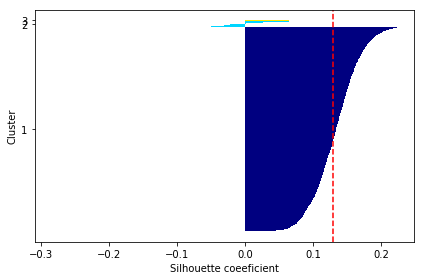

array([0, 0, 0, ..., 0, 0, 0])

In [201]:
kmsilhouette(5,enum_data,0)

In [197]:
show_topic(10,5,enum_data,ver2_count,0)

Topic  0
2005
['gans', 'accounting', 'consent', 'concerned', 'asymptotically', 'aggregate', 'firewall', 'closing', 'definition', 'cultural']
Topic  1
73
['final', 'autoregressive', 'answered', 'biology', 'discretization', 'compare', 'dollar', 'differed', 'compositional', 'adversarial']
Topic  2
2
['gcc', 'gb']
Topic  3
167
['expressiveness', 'external', 'dropping', 'handling', 'construction', 'calculated', 'conjecture', 'brief', 'diameter', 'distilling']
Topic  4
50
['associating', 'dense', 'detailed', 'contour', 'arrival', 'extrapolation', 'buddy', 'hub', 'arbitrary', 'benchmark']


這個 model 看起來沒辦法分到 5 個呢

2 Clusters score =  0.14599619953579532
3 Clusters score =  0.11560495821063924
4 Clusters score =  0.12983421611044738
5 Clusters score =  0.10653693613627598
6 Clusters score =  0.028276171920345643
7 Clusters score =  0.02343750144301605
8 Clusters score =  0.02317608655758787
9 Clusters score =  0.02506345060693926
10 Clusters score =  0.00944206879294414
11 Clusters score =  0.010178613836928984
12 Clusters score =  0.018343479042492606
13 Clusters score =  0.026240853554694476
14 Clusters score =  0.023886065239404022


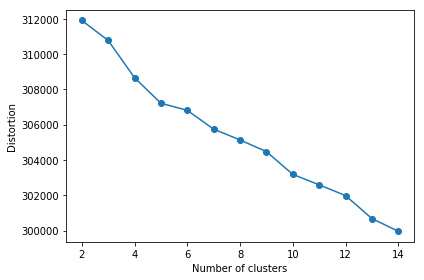

In [165]:
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,
                    init='random',
                    n_init=10,
                    max_iter=400,
                    tol=1e-04,
                    random_state=0)
        y_km = km.fit_predict(pre4_data)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(pre4_data, y_km, metric='euclidean'))

    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

選3 和5 <br />3 cluster point 還不錯 5 看起來像 elbow point

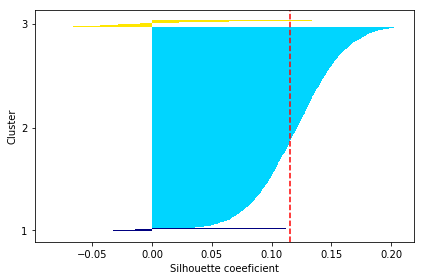

array([1, 1, 1, ..., 1, 1, 1])

In [202]:
kmsilhouette(3,pre4_data,0)

In [198]:
show_topic(10,3,pre4_data,pre4_c,0)

Topic  0
31
['corollari', 'possibl', 'polar', 'client', 'decoupl', 'earlier', 'monoton', 'parser', 'hypothes', 'domin']
Topic  1
2194
['adaboost', 'opportunist', 'element', 'ensur', 'agenda', 'binari', 'knapsack', 'gene', 'byproduct', 'flaw']
Topic  2
72
['multibox', 'cepstral', 'becaus', 'illumin', 'inequ', 'commerc', 'hing', 'diverg', 'eager', 'nexu']


第一個 topic 有相關性，可能性，還有假設
第二個 topic 和第三個 topic 有重覆到，都是在說關於 ML 的東西，

In [179]:
def showtopic(N_clus,N_t_words ,clus ,label , count):
    words = count.get_feature_names()
    silhouette_vals = silhouette_samples(clus, y_km, metric='euclidean')
    for n in range(N_clus):
        val = []
        index = []
        for i,a in enumerate(label):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)

        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(N_t_words): 
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

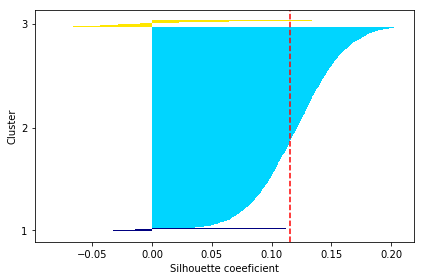

array([1, 1, 1, ..., 1, 1, 1])

In [203]:
kmsilhouette(5,pre4_data,0)

In [204]:
show_topic(10,5,pre4_data,pre4_c,0)

Topic  0
114
['inspect', 'carv', 'financi', 'orthogon', 'flow', 'morphosyntact', 'dirichlet', 'programmat', 'conserv', 'progress']
Topic  1
1981
['opportunist', 'adaboost', 'element', 'agenda', 'flaw', 'ensur', 'binari', 'gene', 'byproduct', 'knapsack']
Topic  2
39
['build', 'grade', 'million', 'member', 'handl', 'consent', 'exacerb', 'botnet', 'explain', 'bitext']
Topic  3
90
['confound', 'perhap', 'contract', 'deliveri', 'asymmetr', 'mainten', 'phase', 'digit', 'path', 'narrow']
Topic  4
73
['multibox', 'cepstral', 'becaus', 'illumin', 'inequ', 'commerc', 'diverg', 'hing', 'eager', 'artifici']


<h1>K-means++</h1>

2 Clusters score =  0.14282492833802904
3 Clusters score =  0.14204212555983795
4 Clusters score =  0.0313022937454401
5 Clusters score =  0.02852708535728959
6 Clusters score =  0.09496180246903756
7 Clusters score =  0.029051301887361516
8 Clusters score =  0.028025815950847414
9 Clusters score =  0.0484763479556142
10 Clusters score =  0.008598118816276708
11 Clusters score =  0.01954783290051384
12 Clusters score =  0.016361226049077072
13 Clusters score =  0.024982128377342518
14 Clusters score =  0.006939167525985432


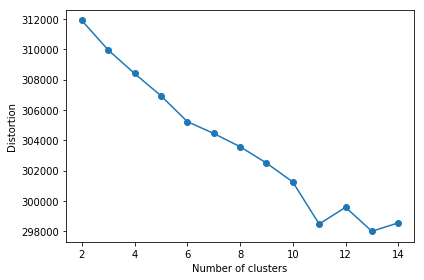

In [169]:
    distortions = []
    for i in range(2,15):
        km = KMeans(n_clusters=i,init='k-means++',n_init=10,max_iter=400,tol=1e-04,random_state=0)
        y_km = km.fit_predict(pre4_data)
        distortions.append(km.inertia_)
        print(i, 'Clusters score = ',silhouette_score(pre4_data, y_km, metric='euclidean'))

    plt.plot(range(2, 15), distortions, marker = 'o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.tight_layout()
    plt.show()

能選的就是 3 和 6

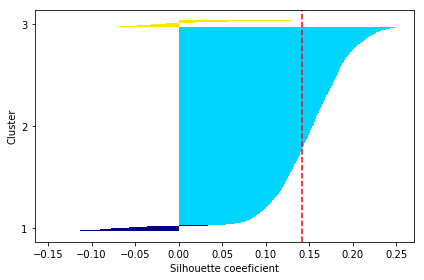

array([1, 1, 1, ..., 1, 1, 1])

In [205]:
kmsilhouette(3,pre4_data,1)

In [207]:
show_topic(10,3,pre4_data,pre4_c,1)

Topic  0
64
['path', 'financi', 'morphosyntact', 'deliveri', 'contract', 'inspect', 'pagerank', 'mainten', 'conserv', 'briefli']
Topic  1
2159
['opportunist', 'adaboost', 'element', 'ensur', 'agenda', 'flaw', 'knapsack', 'gene', 'byproduct', 'binari']
Topic  2
74
['multibox', 'cepstral', 'becaus', 'illumin', 'inequ', 'commerc', 'hing', 'diverg', 'eager', 'artifici']


雖然有分出一些主題，但有些 topic 真的看不出來它的連結和相關性，不過可以看的出來和 kmeans 相差很少，會不會是 iteration 數太少呢?

In [234]:
km = KMeans(n_clusters=3,init='k-means++',n_init=10,max_iter=1000,tol=1e-04,random_state=0)
y_km = km.fit_predict(pre4_data)

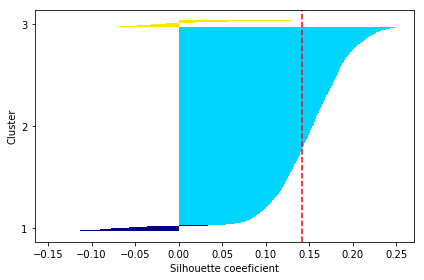

In [235]:
    silhouette_vals = silhouette_samples(pre4_data, y_km, metric='euclidean')
    cluster_labels = np.unique(y_km)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_km == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,edgecolor = 'none', color = color)
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')
    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()

和上圖幾乎相差無幾，看來是分不太出來!

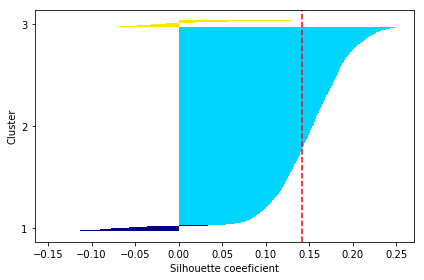

array([1, 1, 1, ..., 1, 1, 1])

In [236]:
kmsilhouette(6,pre4_data,1)

In [208]:
show_topic(10,6,pre4_data,pre4_c,1)

Topic  0
70
['beauti', 'conceiv', 'interpol', 'configur', 'manifest', 'adapt', 'oppos', 'programmat', 'progress', 'interpos']
Topic  1
54
['path', 'financi', 'morphosyntact', 'pagerank', 'deliveri', 'conserv', 'contract', 'briefli', 'flight', 'carv']
Topic  2
72
['multibox', 'cepstral', 'becaus', 'illumin', 'inequ', 'commerc', 'hing', 'diverg', 'eager', 'artifici']
Topic  3
1
['inspect']
Topic  4
2061
['adaboost', 'binari', 'element', 'ensur', 'agenda', 'knapsack', 'gene', 'flaw', 'byproduct', 'opportunist']
Topic  5
39
['paus', 'consensu', 'payment', 'fashion', 'acceler', 'public', 'edit', 'immens', 'increas', 'feedback']


很多 topic 單字便超少，分得不好

In [209]:
ag = pre4_data.toarray()
for i in range(2,10):
    ac = AgglomerativeClustering(n_clusters=i,
                             affinity='euclidean',
                             linkage='complete')
    y_ac = ac.fit_predict(ag)
    print(i, 'Clusters score = ',silhouette_score(ag, y_ac, metric='euclidean'))

2 Clusters score =  0.6135759213688717
3 Clusters score =  0.5851461844213057
4 Clusters score =  0.5240846761429737
5 Clusters score =  0.35448447997838894
6 Clusters score =  0.3547068953505191
7 Clusters score =  0.3549190379995257
8 Clusters score =  0.3547471215527823
9 Clusters score =  0.3340273645784709


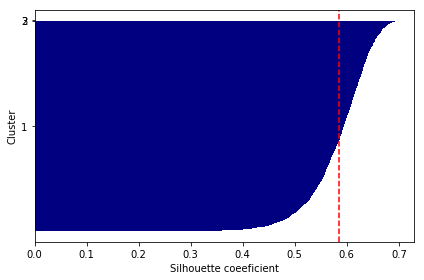

In [210]:
    N = 3
    words = pre4_c.get_feature_names()
    ac = AgglomerativeClustering(n_clusters=N, affinity='euclidean', linkage='complete')

    y_ac = ac.fit_predict(ag)
    cluster_labels = np.unique(y_ac)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ag, y_ac, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_ac == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show()  

In [213]:
    words = pre4_c.get_feature_names()
    silhouette_vals = silhouette_samples(ag,y_ac, metric='euclidean')
    for n in range(N):
        val = []
        index = []
        for i,a in enumerate(y_ac):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)
        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(10):
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

Topic  0
2295
['opportunist', 'adaboost', 'element', 'flaw', 'agenda', 'knapsack', 'ensur', 'gene', 'byproduct', 'binari']
Topic  1
1
['entir']
Topic  2
1
['inspect']


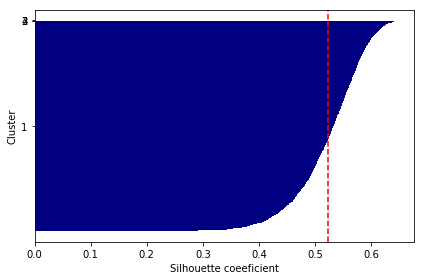

In [218]:
    N = 4
    words = pre4_c.get_feature_names()
    ac = AgglomerativeClustering(n_clusters=N, affinity='euclidean', linkage='complete')

    y_ac = ac.fit_predict(ag)
    cluster_labels = np.unique(y_ac)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ag, y_ac, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_ac == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show() 

In [215]:
    words = pre4_c.get_feature_names()
    silhouette_vals = silhouette_samples(ag,y_ac, metric='euclidean')
    for n in range(N):
        val = []
        index = []
        for i,a in enumerate(y_ac):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)
        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(10):
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

Topic  0
2294
['opportunist', 'adaboost', 'element', 'flaw', 'agenda', 'ensur', 'knapsack', 'gene', 'byproduct', 'binari']
Topic  1
1
['entir']
Topic  2
1
['inspect']
Topic  3
1
['causal']


阿...這沒有用

In [217]:
ag = pre4_data.toarray()
for i in range(2,10):
    ac = AgglomerativeClustering(n_clusters=i,affinity=cosine_distances,linkage='complete')
    y_ac = ac.fit_predict(ag)
    print(i, 'Clusters score = ',silhouette_score(ag, y_ac, metric='cosine'))

2 Clusters score =  -0.00380188393263377
3 Clusters score =  -0.010256147343008594
4 Clusters score =  -0.014087088916224613
5 Clusters score =  -0.014397754060841384
6 Clusters score =  -0.019174232579343316
7 Clusters score =  -0.021591735459645756
8 Clusters score =  -0.024368531371782826
9 Clusters score =  -0.02490360799045703


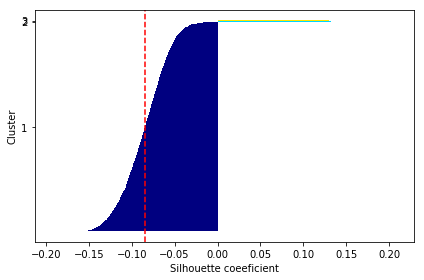

In [219]:
    N = 3
    words = pre4_c.get_feature_names()
    ac = AgglomerativeClustering(n_clusters=i,affinity=cosine_distances,linkage='complete')
    y_ac = ac.fit_predict(ag)
    cluster_labels = np.unique(y_ac)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ag, y_ac, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_ac == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show() 

In [220]:
    words = pre4_c.get_feature_names()
    silhouette_vals = silhouette_samples(ag,y_ac, metric='euclidean')
    for n in range(N):
        val = []
        index = []
        for i,a in enumerate(y_ac):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)
        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(10):
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

Topic  0
2277
['entir', 'grammar', 'advic', 'multibox', 'opinion', 'inspect', 'preferenti', 'attract', 'flow', 'orthogon']
Topic  1
14
['dispatch', 'instanc', 'impress', 'convolv', 'inter', 'gestur', 'radial', 'manufactur', 'principl', 'interf']
Topic  2
6
['collis', 'attack', 'amort', 'genotyp', 'ascertain', 'rademach']


In [221]:
ag = pre4_data.toarray()
for i in range(2,10):
    ac = AgglomerativeClustering(n_clusters=i,affinity=cosine_similarity,linkage='complete')
    y_ac = ac.fit_predict(ag)
    print(i, 'Clusters score = ',silhouette_score(ag, y_ac, metric='cosine'))

2 Clusters score =  -0.00014662519706917454
3 Clusters score =  -0.0009692477455107053
4 Clusters score =  -0.0015922272180750178
5 Clusters score =  -0.001941541522579178
6 Clusters score =  -0.0026127470166253143
7 Clusters score =  -0.003198948516134872
8 Clusters score =  -0.0035208012011775625
9 Clusters score =  -0.003946465704481684


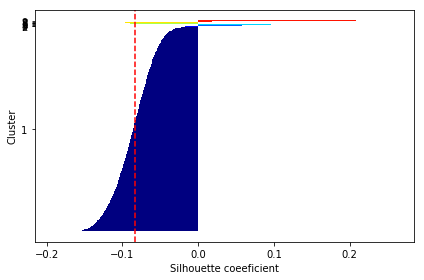

In [223]:
    N = 3
    words = pre4_c.get_feature_names()
    ac = AgglomerativeClustering(n_clusters=i,affinity=cosine_distances,linkage='complete')
    y_ac = ac.fit_predict(ag)
    cluster_labels = np.unique(y_ac)
    y_ax_lower, y_ax_upper = 0, 0
    yticks = []
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(ag, y_ac, metric='euclidean')

    for i, c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_ac == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height = 1.0,
                 edgecolor = 'none', color = color)
    
        yticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouette_vals)
    
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color = 'red', linestyle = '--')

    plt.yticks(yticks, cluster_labels + 1)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coeeficient')

    plt.tight_layout()
    plt.show() 

In [224]:
    words = pre4_c.get_feature_names()
    silhouette_vals = silhouette_samples(ag,y_ac, metric='euclidean')
    for n in range(N):
        val = []
        index = []
        for i,a in enumerate(y_ac):
            if a == n:
                val.append(silhouette_vals[i])
                index.append(i)
        sort = np.argsort(-np.array(val))
        print('Topic ', n )
        print(len(index))
        buf = []
        for i in range(10):
            if i < len(index):
                buf.append(words[index[sort[i]]])
        print(buf)

Topic  0
2230
['entir', 'grammar', 'advic', 'multibox', 'opinion', 'inspect', 'preferenti', 'attract', 'orthogon', 'flow']
Topic  1
8
['exce', 'exceed', 'command', 'collector', 'privat', 'clarifi', 'rack', 'dream']
Topic  2
6
['collis', 'attack', 'amort', 'genotyp', 'ascertain', 'rademach']


分得比 kmeans 還糟糕...

讓我選的話，我會想把它分成 3 群，用 LDA 做，因為雖然有些單字有點相近，但是在 topic 中還是可以分出這個主題和現實生活中 ML 研究的連結。

In [228]:
top_words = 10
feature_token = pre4_c.get_feature_names()
for topic_idx, topic in enumerate(best_lda_model_4.components_):
    print("Topic %d:" % (topic_idx + 1))
    print(" ,".join([feature_token[i] for i in topic.argsort()[:-top_words - 1 : -1]]))

Topic 1:
servic ,devic ,secur ,softwar ,control ,mobil ,survey ,program ,tool ,interact
Topic 2:
video ,speech ,recognit ,object ,estim ,input ,sampl ,word ,architectur ,paramet
Topic 3:
queri ,graph ,advertis ,cluster ,sequenc ,recommend ,event ,social ,rank ,memori


<h1>Discussion</h1>

這次的作業蠻困難的，尤其是在對於文字處理不熟悉的狀況，實在是很難去作出很棒的 cluster 再加上這次的東西並不像老師講義中，那麼好的圖，再加上如果對這份文件取 cov_matrix 會output 出很差的 pca score 前幾個 component 對整個 model 的影響力實在太低，會讓我覺得就算用 PCA 來畫圖也非常沒有意義!
所以我才會用 silhouette_vals 去選擇包含在這個 cluster 中的單字，看能不能觀察到甚麼樣的結果，可是非常遺憾的，都沒有辦法分出一個很厲害的群，每一個都有它獨特的特徵，所以很難對 DATA 進行處理，有想過是不是能把 model train 等單字從 data 中拿掉，但是我又想到老師說的 outlawer ，不敢隨意地去把這些資料處理掉，最後還是不敢對他們進行清除掉，所以我做了一些 preprocess 像是把字變成字根，但是因為英文不夠好，變成字根後反而很難分析，就算把它貼到 google 中，還是很沒有辦法去強調這應該就是什麼，常常會發現 google 偵測到的語言不是英文，而是法文，義大利文等，會讓我感到更加的困惑，所以只能從 google 搜尋的結果去猜測大致上單字的意思，所以變得很不直觀。

在這次作業中，我分析的方法主要是:
1.用單字來分
2.用文章來分
方法就是直接對矩陣取轉置就可以了，在 document cluster 會發現它的 performance 比較差，但是卻是不可以忽略的，在寫這份作業的時候常常會看到後面 output 出來的結果瘋狂地去修改前面的東西。

在這次作業中，選擇 hyperparameter 的方法主要是靠跑回圈 print 出分數或是畫出 distortion 圖，尋找 elbow point 來決定，另外演算法的細節主要是參考老師講義中的設定，同時也有去搜尋別人怎麼做 document clustering 去選參數。

在這次作業中，主要的心得是:
1.unsupervised learning 是沒有標準答案的，所以很多地方都要靠著自己的觀察和想像來拼湊答案
2.想要分出很好的 cluster 是非常困難的，尤其是在主題非常類似的文章中，我覺得比較能有幫助的方法是靠 DL 畢竟這個 model 省略了一些在文章中蠻重要的資訊，所以會更難去區分。
3.查了很多 document 去了解 document 裡面有什麼 option 可以 call
4.搜尋蠻多 api 做視覺化的，但是卻發現蠻多 api 的意義很低，因為我們的 principal component 佔得比很低，會讓這個圖的說服力少很多，所以在 k-means 之後的分類手法中，我就很少去劃出這個點分佈在空間的何處了。
5.原來我對 lda 的了解這麼淺，以後再呼叫 api 時真的要好好去看裡面的 document 包含了什麼!

<h1>Conclusion</h1>

NLP 真的是博大精深的一個領域，同時 machine learning 也讓人十分著迷，一如老師在上課所說的，這門課主要是在教導概念，和如何實作，所以當我在呼叫 api 失敗後，會比較難<br />
去分析自己的問題出在哪裡，畢竟 NLP 本身就是一個又深又廣的領域，同時這份作業也是我寫最久的一份了，因為實在是做不太出好的結果!

<h1>Reference</h1>

https://zh.wikipedia.org/wiki/%E4%BD%99%E5%BC%A6%E7%9B%B8%E4%BC%BC%E6%80%A7
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_samples.html
https://pythonhosted.org/scikit-fuzzy/auto_examples/plot_cmeans.html
https://www.kaggle.com/ykhorramz/lda-and-t-sne-interactive-visualization